# Polymer dynamics with varying temperature and forces

First run the example to train and save the trained model
```shell
cd ./examples/polymer_dynamics
python polymer_dynamics_temperature.py
```

The results will be saved to a path in `./outputs/...` that appropriately time-stamped.

The rest of the notebook will perform analysis on the outputs.

In [1]:
import os
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
from tqdm import tqdm

## Read saved model and config

In [2]:
from omegaconf import OmegaConf
from polymer_dynamics_temperature import build_model
from datasets import load_dataset

In [ ]:
path = "outputs/2025_04_15-17_13_13"
config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
model_template = build_model(config)
trained_model = eqx.tree_deserialise_leaves(os.path.join(path, "model.eqx"), model_template)

## Predictions

We first test the predictions of the mean, standard deviation and the unfolding time distribution.

### Holdout data

Load test data

In [5]:
test_data = load_dataset("MLDS-NUS/Wis_Holdout_Reduced").with_format("numpy")

In [37]:
from examples.utils.sde import SDEIntegrator
integrator = SDEIntegrator(model=trained_model, state_dim=config.dim)

Helper functions

In [38]:
@jax.jit
def compute_unfolding_time(traj):
    unfolded_extension = traj[:, -1, 0]
    threshold = 0.95 * unfolded_extension
    first_index = jnp.argmin(traj[:, :, 0] <= threshold[:, None], axis=1)
    return first_index

In [39]:
def compare_statistics(test_data, test_split, key):

    # Extract data
    test_data_fast = test_data[f"{test_split}_fast"]
    test_data_medium = test_data[f"{test_split}_middle"]
    test_data_slow = test_data[f"{test_split}_slow"]
    test_x = [test_data_fast["x"], test_data_medium["x"], test_data_slow["x"]]
    test_args = [test_data_fast["args"][0,0], test_data_medium["args"][0,0], test_data_slow["args"][0,0]]

    # Generate predicted trajectories
    num_runs = test_data_fast.shape[0]
    keys = jr.split(key, 3)
    predicted_trajectories = []
    for key, traj, args in zip(keys, test_x, test_args):
        init_conditions = jnp.repeat(traj[0, 0, :][None, :], num_runs, axis=0)
        bm_keys = jr.split(key, num_runs)
        sol = integrator.parallel_solve(
            key=bm_keys,
            initial_conditions=init_conditions,
            t0=0.0,
            t1=config.dt * test_x[0].shape[1],
            dt=config.dt,
            args=args,
        )
        predicted_trajectories.append(sol.ys)

    # Compute statistics
    fig, ax = plt.subplots(3, 3, figsize=(12, 8), layout="constrained")
    for a, true, pred in zip(ax, test_x, predicted_trajectories):
        true_mean = jnp.mean(true, axis=0)
        pred_mean = jnp.mean(pred, axis=0)

        a[0].plot(true_mean[:, 0], label="True")
        a[0].plot(pred_mean[:, 0], label="Pred")
        a[0].set_title("Mean")

        true_std = jnp.std(true, axis=0)
        pred_std = jnp.std(pred, axis=0)

        a[1].plot(true_std[:, 0], label="True")
        a[1].plot(pred_std[:, 0], label="Pred")
        a[1].set_title("Standard deviation")

        true_unfolding_time = compute_unfolding_time(true)
        pred_unfolding_time = compute_unfolding_time(pred)

        a[2].hist(true_unfolding_time, label="True", alpha=0.5, density=True, bins=20)
        a[2].hist(pred_unfolding_time, label="Pred", alpha=0.5, density=True, bins=20)
        a[2].set_title("Unfolding time")

    for a in ax.flatten():
        a.set_xlabel(r"$t$")

    for a, label in zip(ax[:, 0], ["Fast", "Medium", "Slow"]):
        a.set_ylabel(label)

    fig.suptitle(f"Comparison of Statistics for {test_split}", fontsize=16)

Compare statistics

5it [04:54, 58.80s/it]


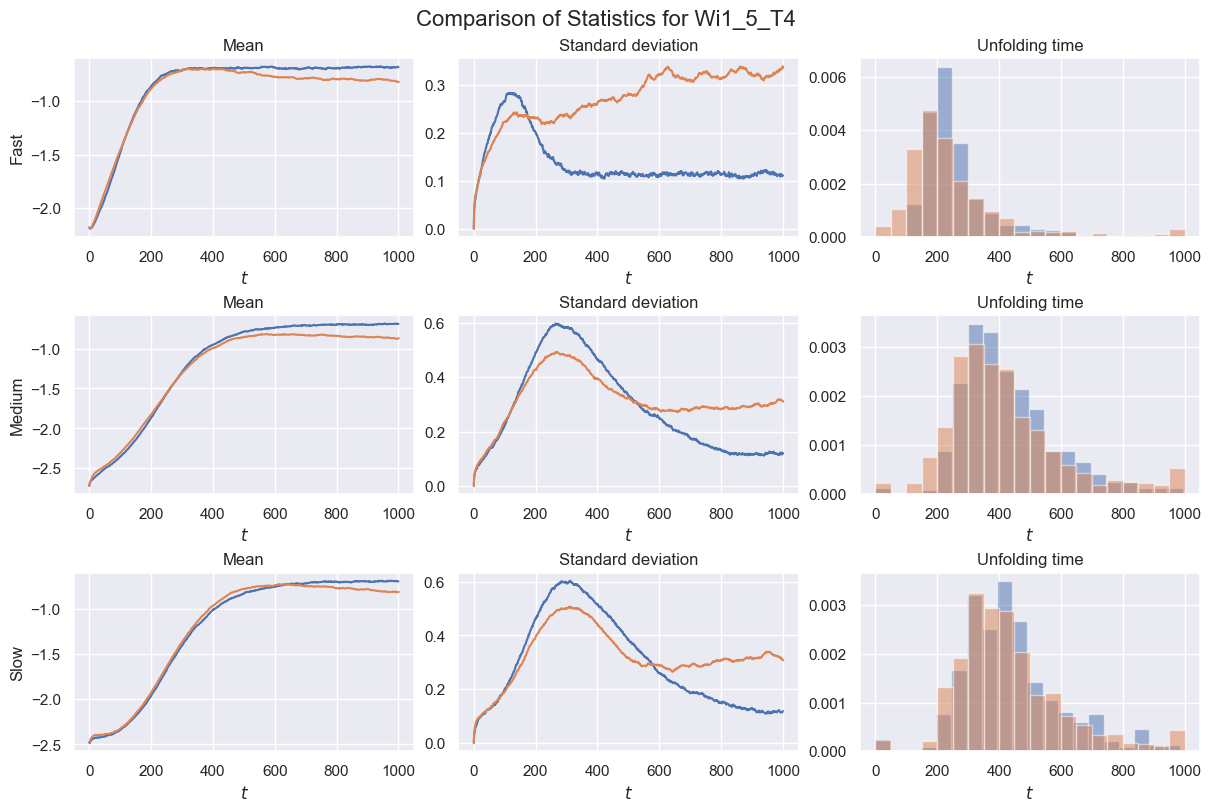

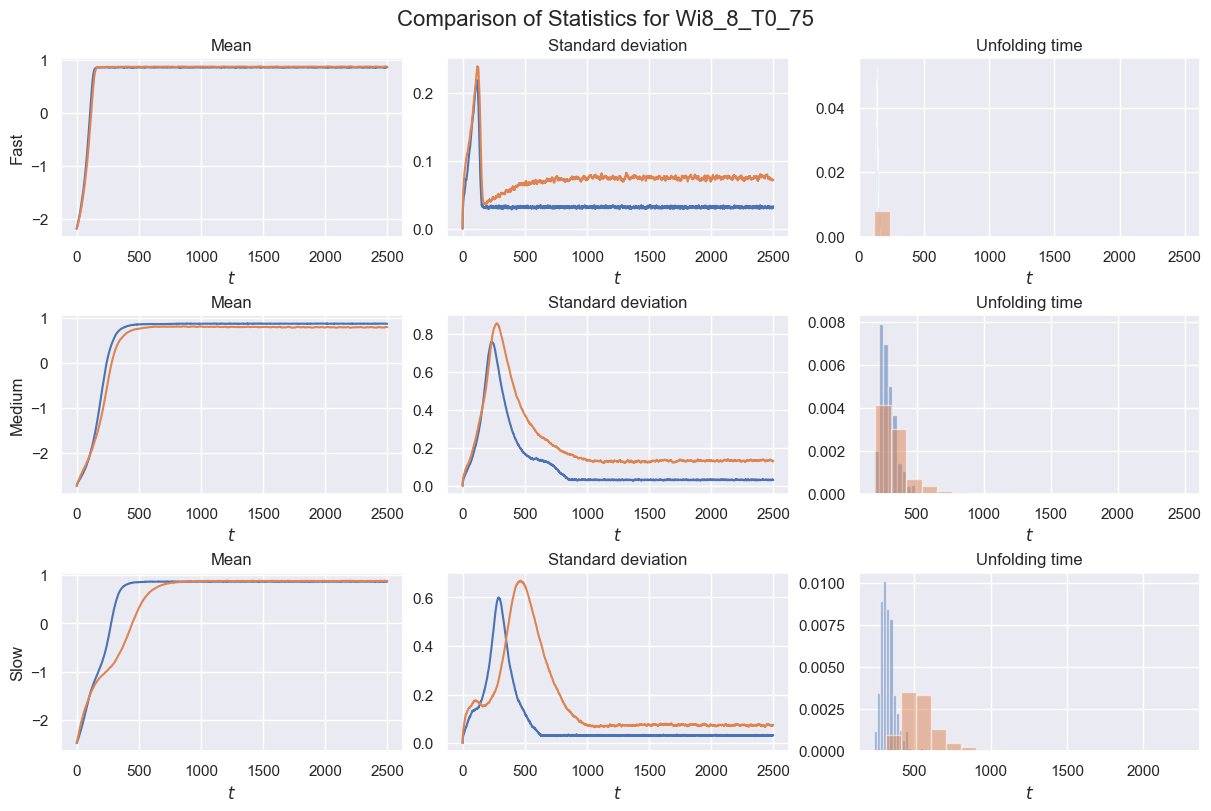

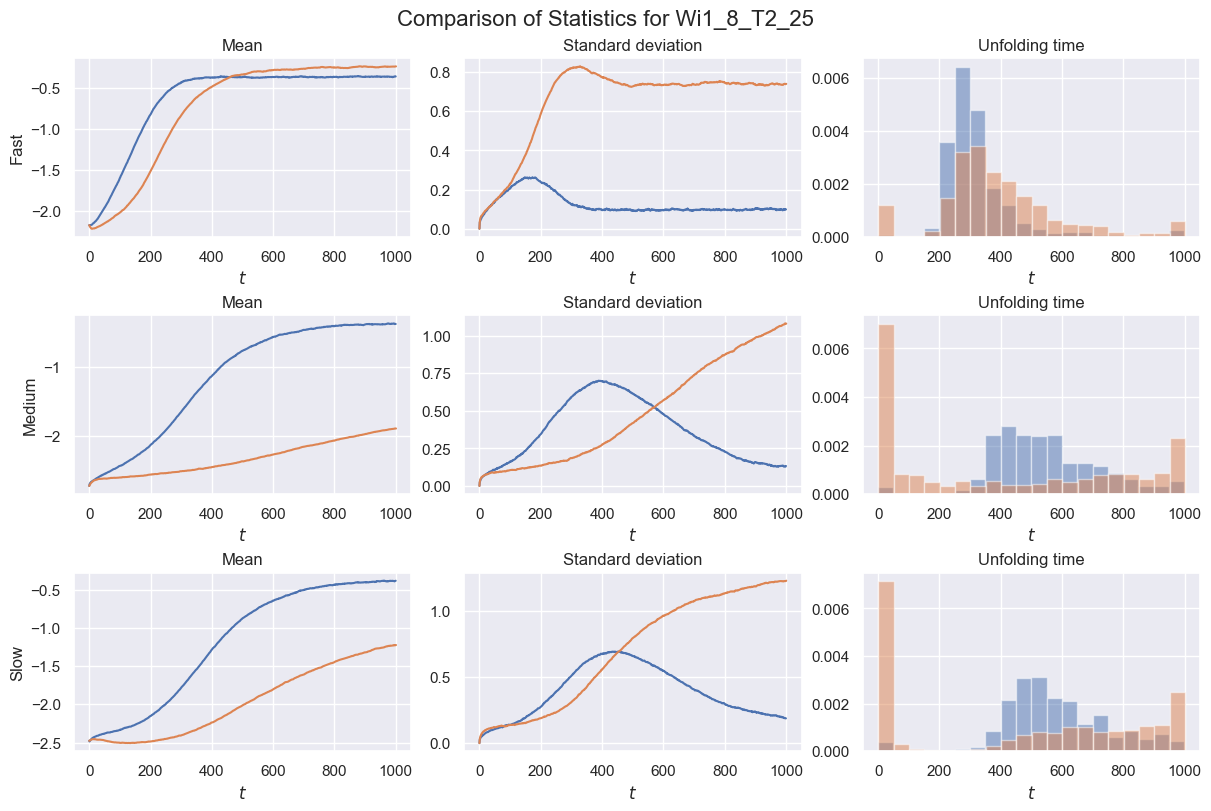

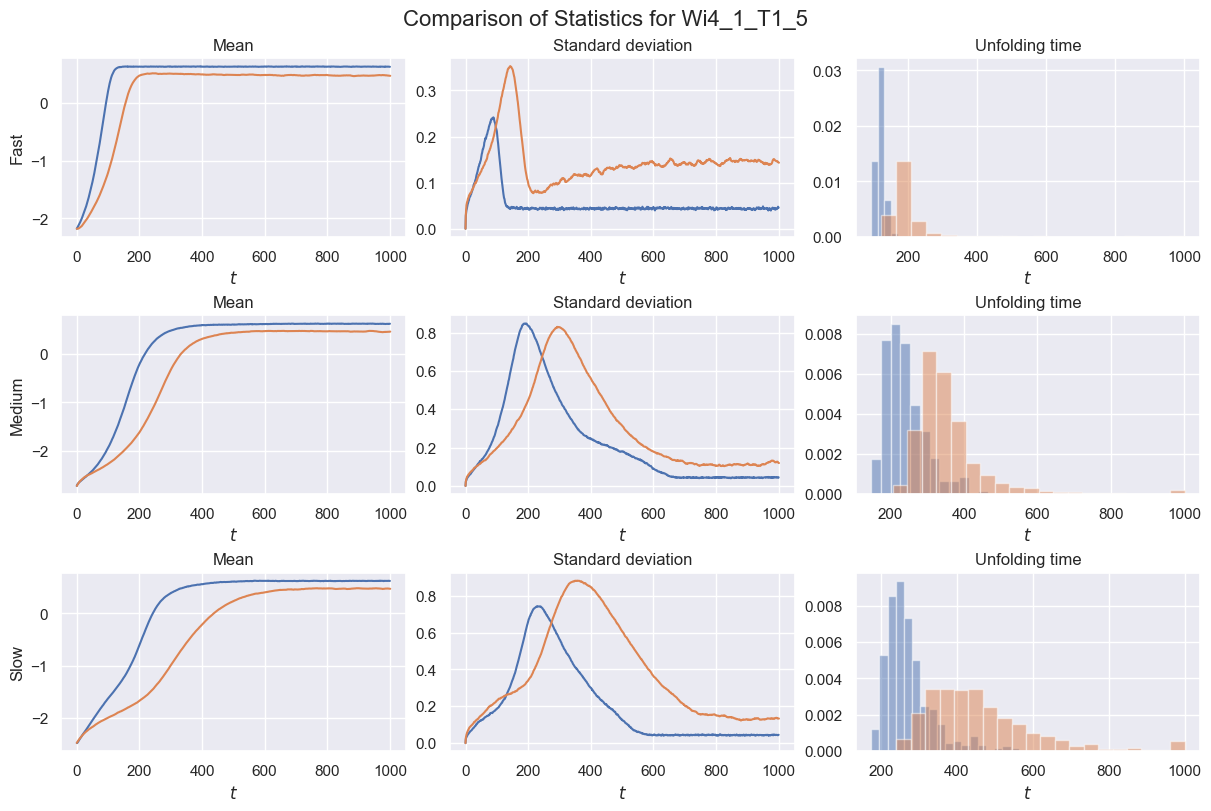

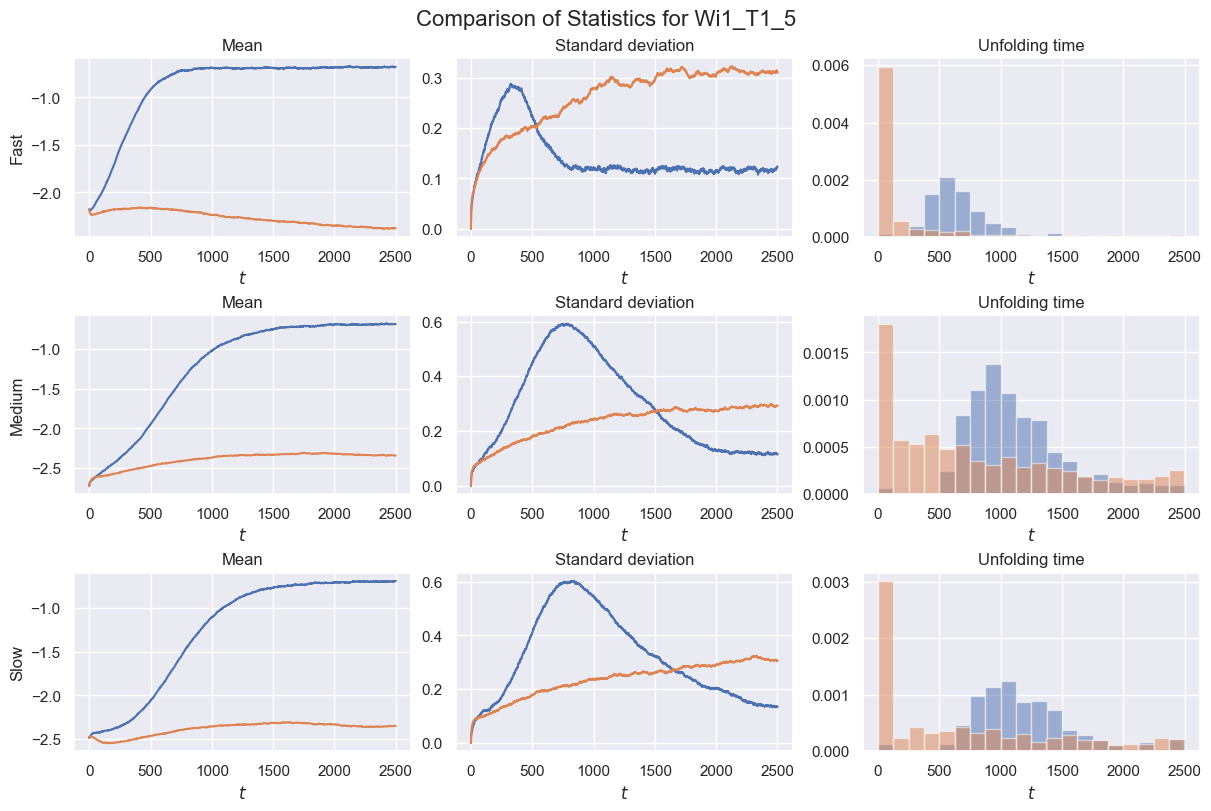

In [ ]:
test_splits = set(k.rsplit('_', 1)[0] for k in test_data.keys())  # all splits
keys = jr.split(jr.PRNGKey(config.model.seed + 123), len(test_splits))

for key, test_split in tqdm(zip(keys, test_splits)):
    compare_statistics(test_data, test_split, key)

### Validation data

In [32]:
test_data = load_dataset("MLDS-NUS/Wis_Validation_Reduced").with_format("numpy")

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Wi5_T1_fast-00000-of-00001.parquet:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Wi5_T1_middle-00000-of-00001.parquet:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Wi5_T1_slow-00000-of-00001.parquet:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Wi3_T0_25_slow-00000-of-00001.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

Wi3_T0_25_middle-00000-of-00001.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

Wi3_T0_25_fast-00000-of-00001.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

Generating Wi10_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi10_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi10_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi0_7_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi0_7_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi0_7_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi1_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi1_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi1_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi1_7_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi1_7_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi1_7_T1_slow split:   0%|          | 0/110 [00:00<?, ? examples/s]

Generating Wi1_2_T1_fast split:   0%|          | 0/110 [00:00<?, ? examples/s]

Generating Wi1_2_T1_middle split:   0%|          | 0/110 [00:00<?, ? examples/s]

Generating Wi1_2_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi2_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi2_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi2_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi7_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi7_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi7_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi5_T1_fast split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi5_T1_middle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi5_T1_slow split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating Wi3_T0_25_slow split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating Wi3_T0_25_middle split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating Wi3_T0_25_fast split:   0%|          | 0/1000 [00:00<?, ? examples/s]

9it [06:49, 45.50s/it]


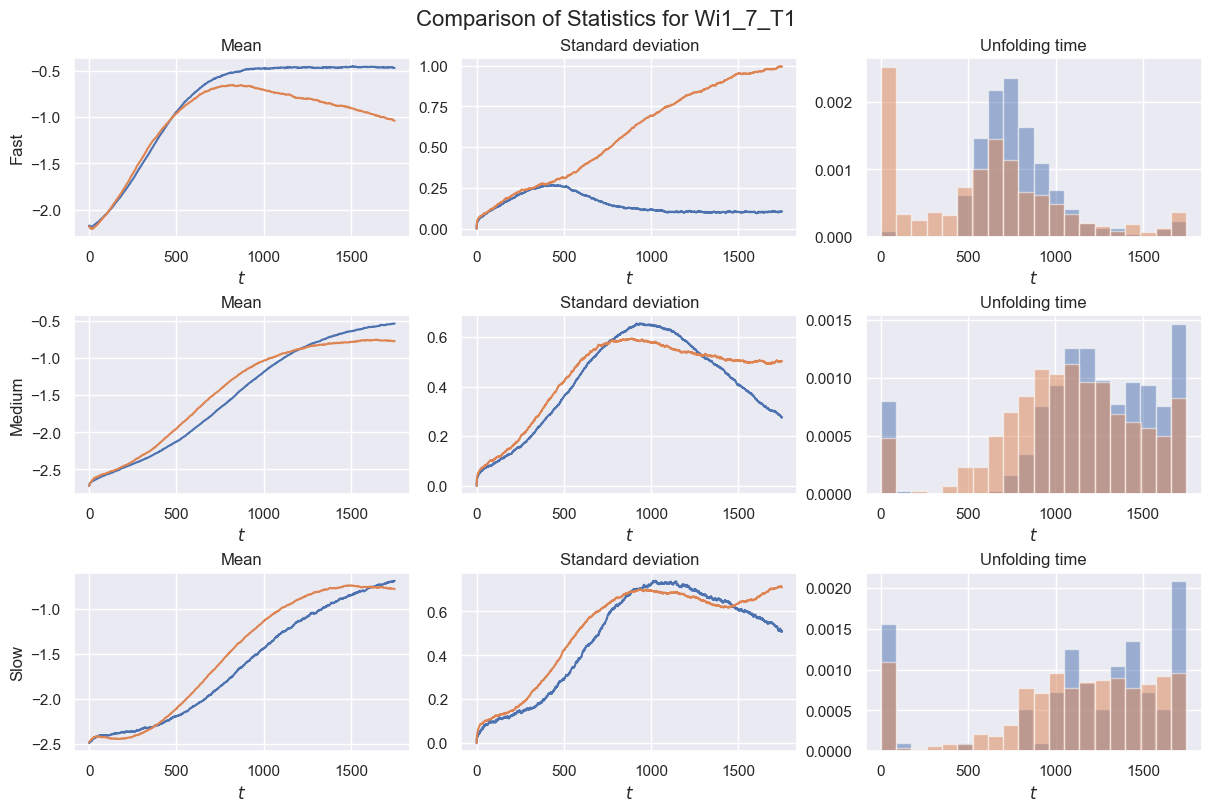

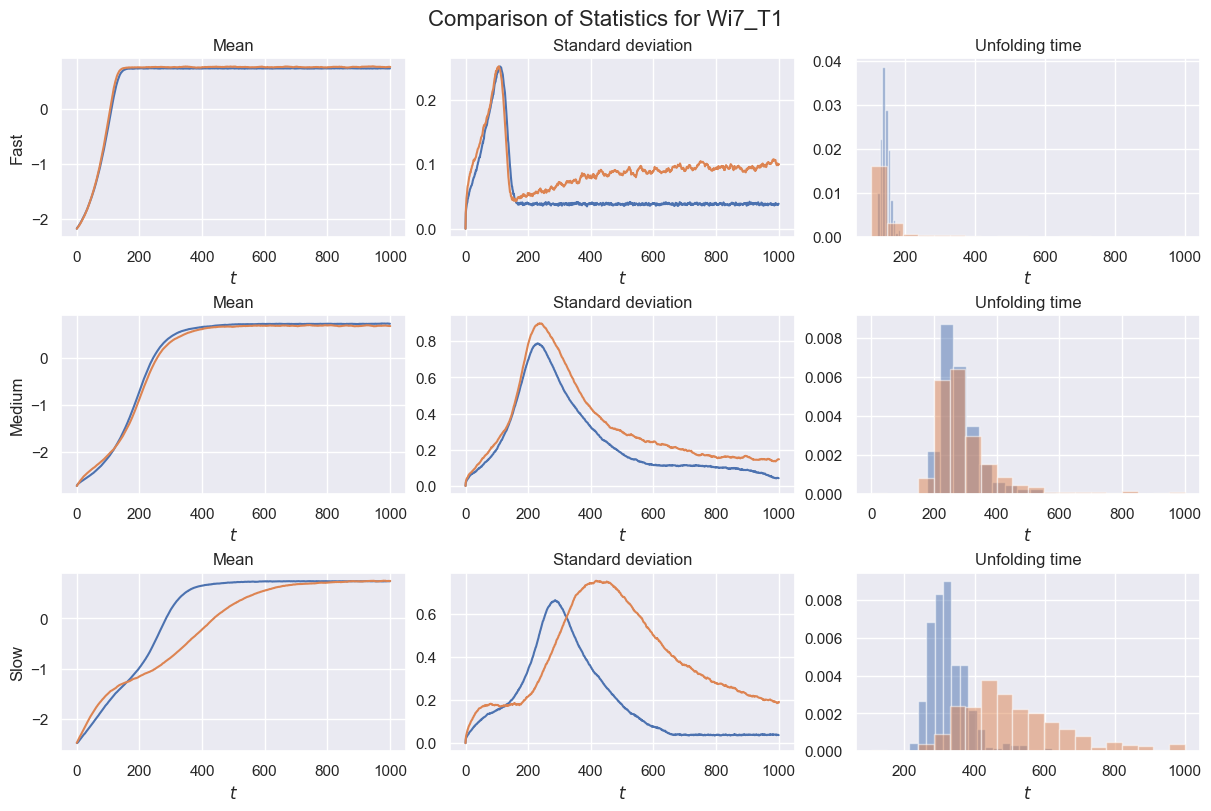

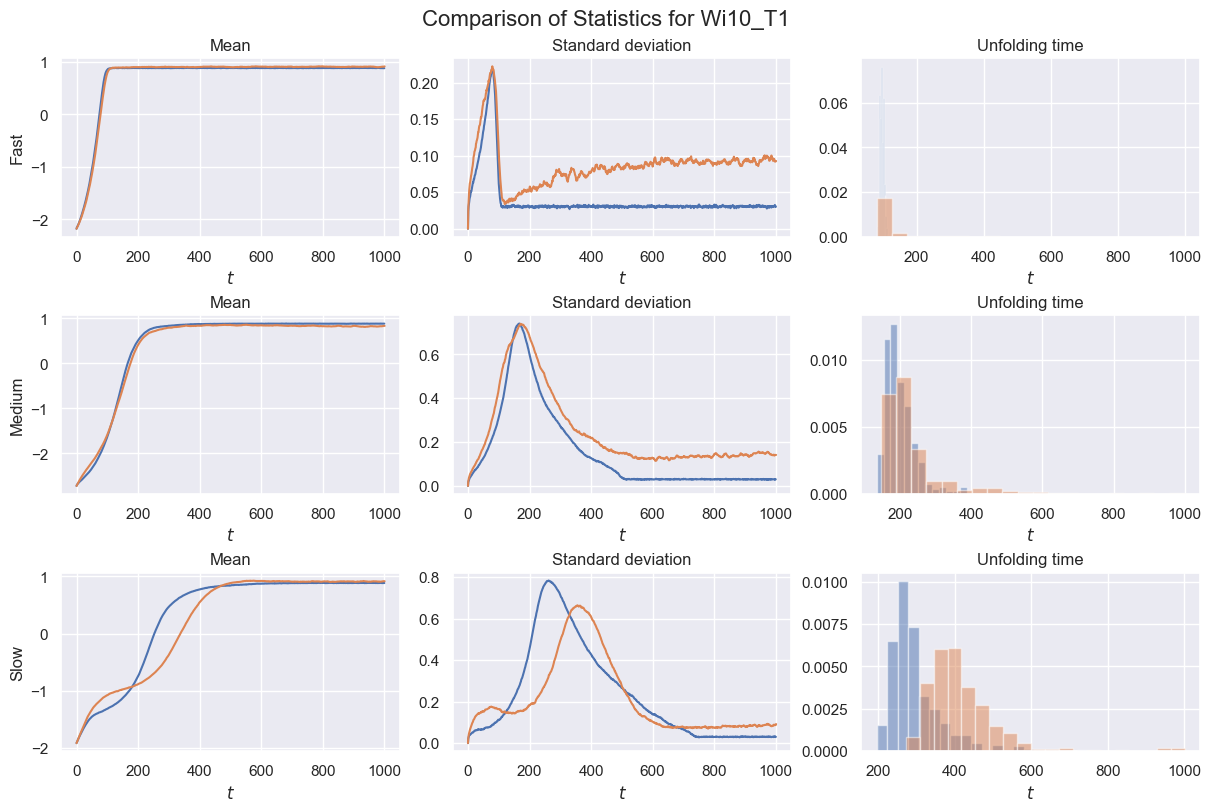

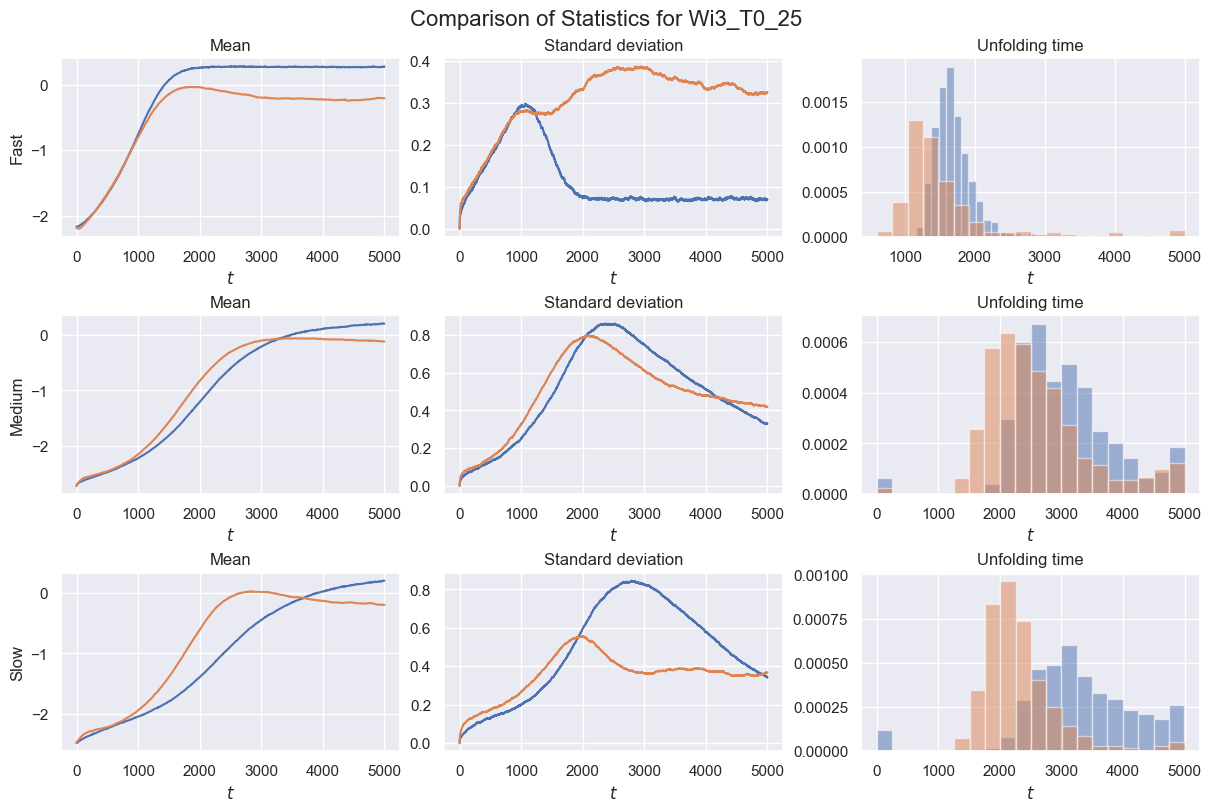

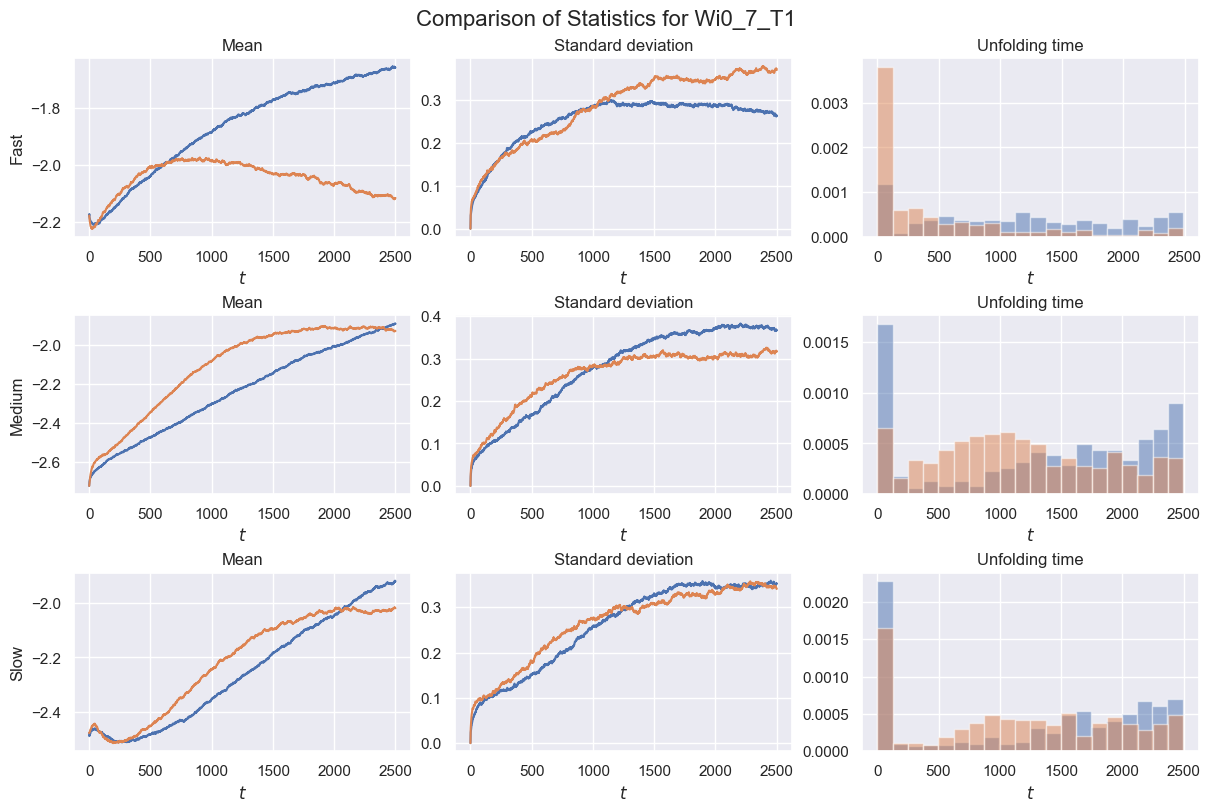

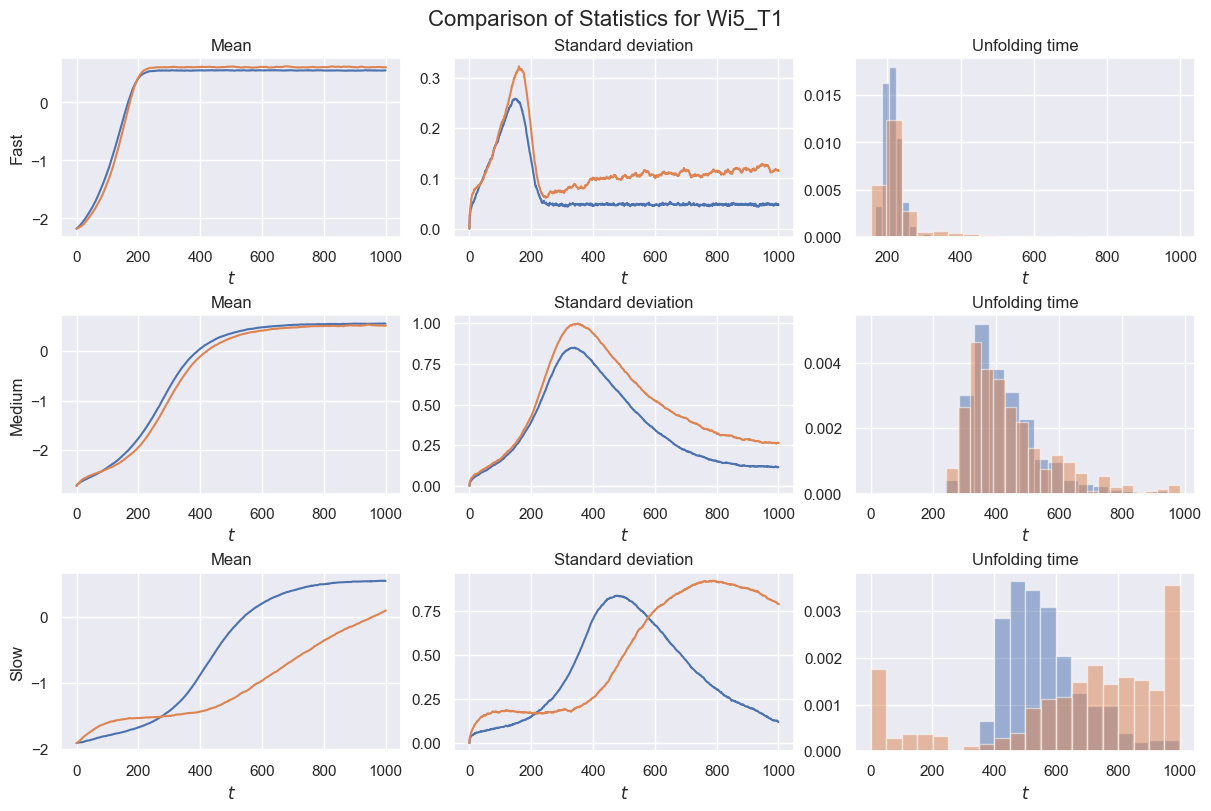

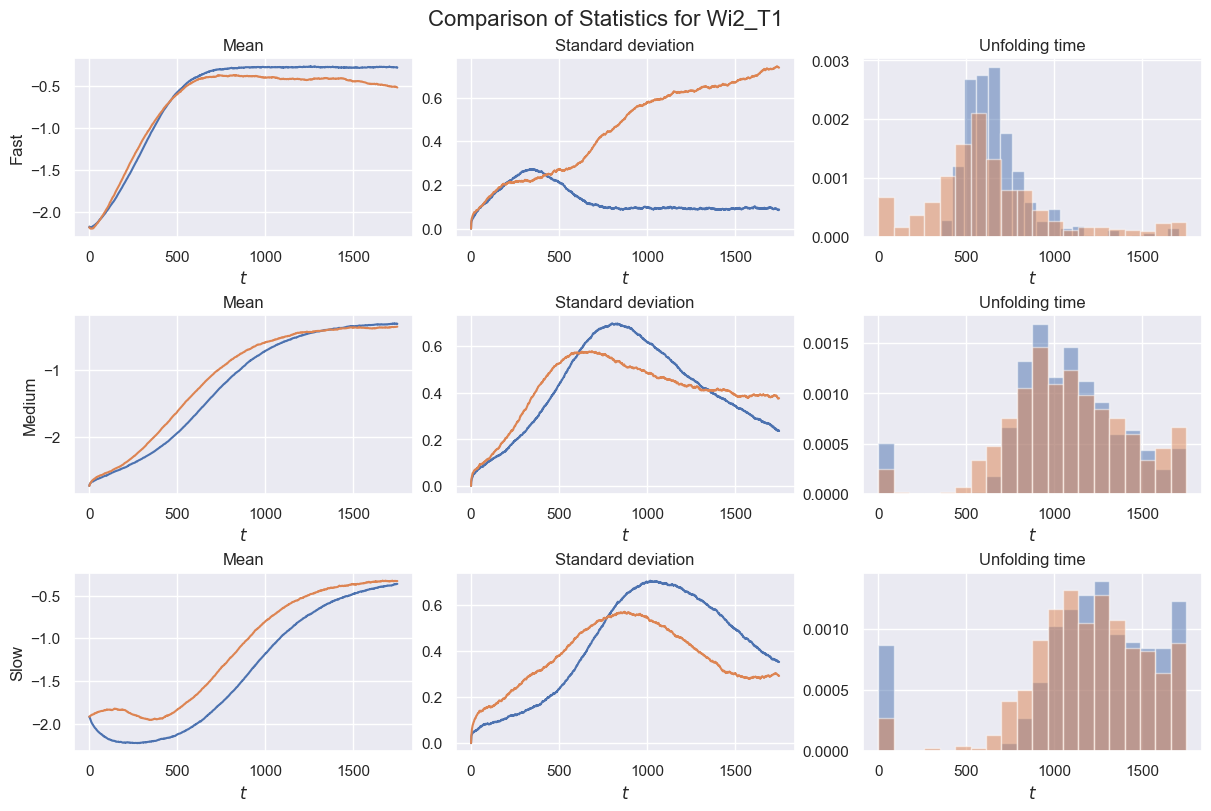

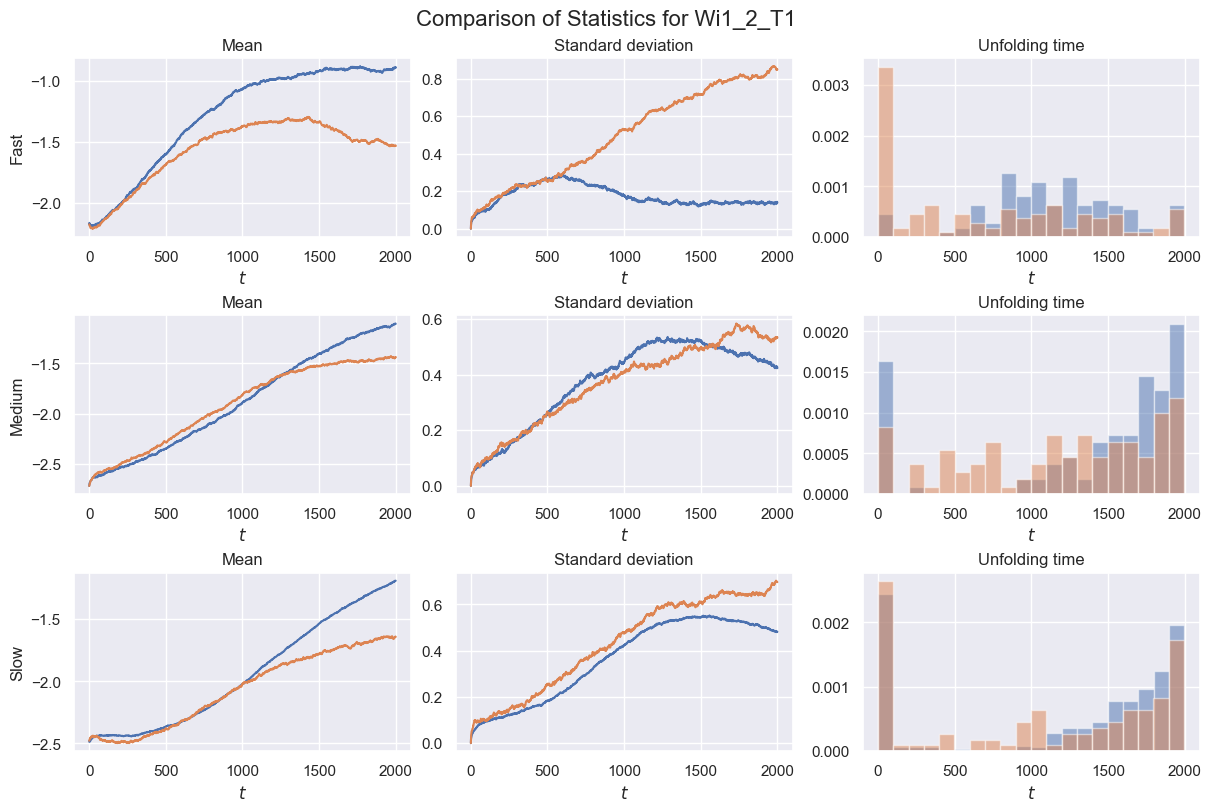

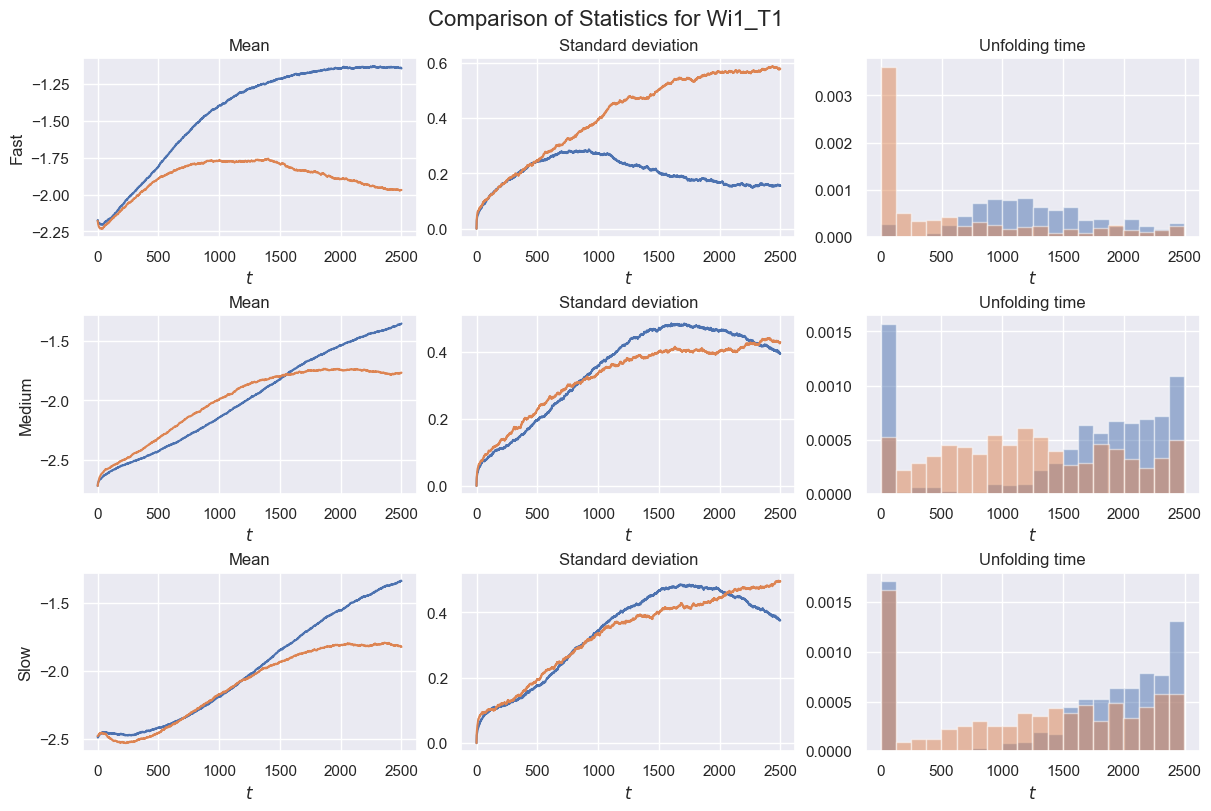

In [41]:
test_splits = set(k.rsplit('_', 1)[0] for k in test_data.keys())  # all splits
keys = jr.split(jr.PRNGKey(config.model.seed + 123), len(test_splits))

for key, test_split in tqdm(zip(keys, test_splits)):
    compare_statistics(test_data, test_split, key)

## Potential landscape

Next, let us compare the potential landscape.

As described in the paper, we will visualise 2D projections of the 3D potential defined by
$$
    v(z_1, z_2) := \inf_{z_3} V(z_1, z_2, z_3)
$$
We know from large deviations theory that for sufficiently low temperatures, this approximation is valid.

In [6]:
z1_min, z1_max = -3, 1
z2_min, z2_max = -2, 2
z3_min, z3_max = -6, 6
num_samples_aux_dimension = 128  # number of samples to take infimum over

In [7]:
def V(z1, z2, z3, T, Wi):
    z = jnp.array([z1, z2, z3])
    args = jnp.array([T, Wi])
    return trained_model.potential(z, args)

In [8]:
# @jax.vmap
@jax.jit
def V_12(z1, z2, T, Wi):
    z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (None, None, 0, None, None))(z1, z2, z3_test_range, T, Wi))


# @jax.vmap
@jax.jit
def V_13(z1, z3, T, Wi):
    z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (None, 0, None, None, None))(z1, z2_test_range, z3, T, Wi))

# @jax.vmap
@jax.jit
def V_23(z2, z3, T, Wi):
    z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (0, None, None, None, None))(z1_test_range, z2, z3, T, Wi))

In [9]:
num_grid = 100
num_levels = 200
off_set = 1.0
level_start = 0.0
level_end = 500.0
custom_levels = jnp.linspace(level_start, level_end, num_levels)

def get_V_12(T, Wi):
    z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
    z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    V12_grid = jax.vmap(V_12, in_axes=(0, 0, None, None))(Z1.ravel(), Z2.ravel(), T, Wi).reshape(Z1.shape)
    return Z1, Z2, V12_grid

In [10]:
from ipywidgets import interact, FloatSlider

custom_levels = jnp.linspace(level_start, level_end, num_levels)

def plot_potential_contour(T, Wi):
    # Get the Z1, Z2 meshgrid and V12_grid values
    Z1, Z2, V12_grid = get_V_12(T=T, Wi=Wi)

    # Clip values to avoid extremely high values that distort the visualization
    # V12_grid = jnp.clip(V12_grid, a_min=0.0, a_max=level_end)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create contour plot with the custom levels
    contour = ax.contour(Z1, Z2, V12_grid, levels=custom_levels)
    contourf = ax.contourf(Z1, Z2, V12_grid, levels=custom_levels, cmap='viridis', alpha=0.7)

    # Add labels and title
    ax.set_xlabel(r'$Z_1$')
    ax.set_ylabel(r'$Z_2$')
    ax.set_title(f'Potential Landscape $V_{{12}}$ (T={T:.2f}, Wi={Wi:.2f})')

    # Add a color bar
    cbar = fig.colorbar(contourf, ax=ax)
    cbar.set_label('Potential Energy')

    plt.tight_layout()
    plt.show()

# Create sliders for T and F
interact(plot_potential_contour,
         T=FloatSlider(value=1.0, min=0.25, max=10.0, step=0.1, description='T'),
         Wi=FloatSlider(value=1.0, min=0.006, max=4.22, step=0.1, description='Wi'));

interactive(children=(FloatSlider(value=1.0, description='T', max=10.0, min=0.25), FloatSlider(value=1.0, desc…

## Phase Diagram

In [16]:
from scipy.ndimage import minimum_filter

In [17]:
def V(z1, z2, z3, T, Wi):
    z = jnp.array([z1, z2, z3])
    args = jnp.array([T, Wi])
    return trained_model.potential(z, args)

In [18]:
z1_vals = jnp.linspace(-3.0, 1.0, 40)
z2_vals = jnp.linspace(-2.0, 2.0, 40)
z3_vals = jnp.linspace(-6.0, 6.0, 40)

z1_grid, z2_grid, z3_grid = jnp.meshgrid(z1_vals, z2_vals, z3_vals, indexing='ij')
points = jnp.stack([z1_grid, z2_grid, z3_grid], axis=-1).reshape(-1, 3)  # shape: [num_points, 3]

In [19]:
def make_V_fn(V, T, Wi):
    def V_point(z):
        return V(z[0], z[1], z[2], T, Wi)
    return jax.vmap(V_point)

In [20]:
def count_local_minima_3d(V_values_3d):
    V_np = np.array(V_values_3d)  # convert to NumPy
    local_min = (V_np == minimum_filter(V_np, size=3, mode='reflect'))
    return np.count_nonzero(local_min)

In [27]:
T_vals = jnp.linspace(0.25, 10.0, 50)
Wi_vals = jnp.linspace(0.006, 1.0, 60)

minima_counts = np.zeros((len(T_vals), len(Wi_vals)))

for i, T in enumerate(T_vals):
    for j, Wi in enumerate(Wi_vals):
        V_fn = make_V_fn(V, T, Wi)
        V_values = V_fn(points).reshape(len(z1_vals), len(z2_vals), len(z3_vals))
        minima_counts[i, j] = count_local_minima_3d(V_values)

In [28]:
minima_counts_clipped = np.minimum(minima_counts, 3)

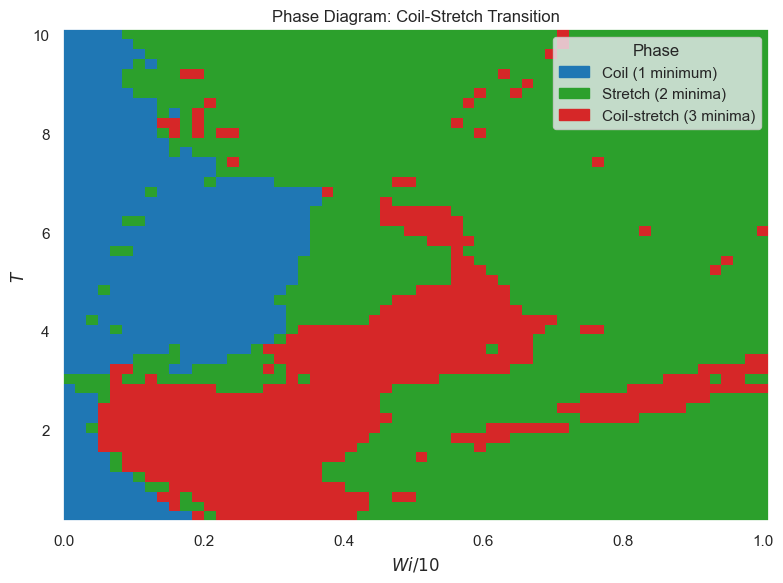

In [29]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import numpy as np

# Define color map and labels
colors = ['#1f77b4', '#2ca02c', '#d62728']  # blue, green, red
labels = ['Coil (1 minimum)', 'Stretch (2 minima)', 'Coil-stretch (3 minima)']
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

# Correct meshgrid: F (x-axis), T (y-axis)
Wi_grid, T_grid = np.meshgrid(Wi_vals, T_vals)  # <- swap order here

plt.figure(figsize=(8, 6))
plt.pcolormesh(Wi_grid, T_grid, minima_counts, cmap=cmap, norm=norm, shading='auto')
plt.xlabel(r'$Wi/10$')
plt.ylabel(r'$T$')
plt.title('Phase Diagram: Coil-Stretch Transition')

# Custom legend
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]
plt.legend(handles=patches, title='Phase', loc='upper right')

plt.tight_layout()
plt.show()